<a href="https://colab.research.google.com/github/spiegel-jpg/Denial_of_Service-8240/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from scipy.stats import norm
import statistics
from google.colab import drive
import pandas as pd
import plotly.express as px
import math
import pywt
from tensorflow.keras.models import load_model

In [203]:
drive.mount('/content/drive') # Mounting the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
proj_dir = '/content/drive/MyDrive/spiegel'

In [205]:
data = pd.read_excel(proj_dir+'/get1.xlsx') # Reading the data

In [206]:
# Indexing the data according to the timestamps from 
# https://data.world/noideabro/frc-attack
data['Time'] = data['Time'].dt.floor('h')
timeseries = data.set_index('Time')

In [207]:
H = 10633   
trH,tsH = int(H/2), int(H/2)                       # Total hours of data we have
pages = pd.read_csv(proj_dir+'/pages.csv')
valid_page = pages['PATH']

In [208]:
pages = pd.read_csv(proj_dir+'/pages.csv')
valid_page = pages['PATH']

quantile = list(valid_page)

In [209]:
valid_page_checker = set(valid_page)
N = len(pages)                      # N is the total pages on the website
                                    # These are all the pages which are services with 200 HTML status code
#  fij represent the total number of requests on ith page (1 ≤ i ≤ N) in the jth hour.


In [210]:
# U is the quantiles 
# timeseries.index[i]
time=set()
for i in range(len(timeseries)):
  time.add(timeseries.index[i])
time = list(sorted(time))
# print(time)
# U = [[0 for i in range(M)] for j in range(int(no_of_quantiles))]
# for i in range(int(no_of_quantiles)):
#   for j in range(M):
#     U[i][j]
print(len(time))

10633


In [211]:
S = [0 for i in range(trH)]
T = [0 for i in range(tsH)]

In [212]:
for i in range(trH):
  requests = timeseries.loc[time[i]]
  no_of_req = int(len(requests))
  request_path = requests['Path']
  request_response = requests['Response']
  if not isinstance(requests, pd.DataFrame):
    if request_response == 200:
        if request_path in quantile:
          S[i]+=1
  else:
    for j in range(no_of_req):
      if request_response[j] == 200:
        if request_path[j] in quantile:
          S[i]+=1

In [213]:
for i in range(trH,H-1,1):
  requests = timeseries.loc[time[i]]
  no_of_req = int(len(requests))
  request_path = requests['Path']
  request_response = requests['Response']
  if not isinstance(requests, pd.DataFrame):
    if request_response == 200:
        if request_path in quantile:
          T[i-trH]+=1
  else:
    for j in range(no_of_req):
      if request_response[j] == 200:
        if request_path[j] in quantile:
          T[i-trH]+=1

In [214]:
# attack boundaries
half = math.floor(len(S)/2)
half_close = math.floor(0.9*len(S))
print(half,half_close,trH,tsH)

2658 4784 5316 5316


For Noise


Rtotal is the total number of requests for H/2 h. Hence, Rtotal is 129616 requests.

In [215]:
R_total_no = int(trH/2)

In [216]:
noise = S[0:R_total_no]
noise_mean = np.mean(noise)
noise_var = np.std(noise)
print(noise_mean, noise_var)

20.224228743416102 38.07358108979375


In [217]:
T_R_total_no = int(trH/2) 

In [218]:
Tnoise = T[0:T_R_total_no]
Tnoise_mean = np.mean(Tnoise)
Tnoise_var = np.std(Tnoise)
print(Tnoise_mean, Tnoise_var)

13.747178329571106 36.25509540399803


In [219]:
# Normal distribution for one of the quantiles according to the formula in the paper.
def noise_generator(begin,end,attack_percentage, mean, var):
  nrange=end-begin
  P=attack_percentage # 0.03 0.05 0.1 0.15 0.2
  x = np.arange(0,nrange, 1)
  gnoise = np.random.normal(P*mean,P*var,nrange)
  for i in range(nrange):
    if gnoise[i]<0:
      gnoise[i]=-gnoise[i]
  return gnoise

### **Here starts our implementation (Graph)**




In [220]:
# # Quantile 1 with added noise
attack_percentage=0.5
noise1_data = noise_generator(half,half_close,attack_percentage,noise_mean,noise_var)
S_mod = noise1_data + S[half:half_close]
S0=list()  # sequence 0 with added noise
for i in range(trH):
  if i<half:
    S0.append(S[i])
  elif i>=half and i<half_close:
    S0.append(S_mod[i-half])
  elif i>=half_close:
    S0.append(S[i])
df = pd.DataFrame(dict(
    x = np.arange(0,trH,1),
    y = np.array(S0)
))
df1 = pd.DataFrame(dict(
    x = np.arange(0,trH,1),
    y = np.array(S0)-np.array(S)
))

# new_df = df - df_no_noise
fig = px.line(df, x="x", y="y", title="Quantile 1 With added noise") 
fig.add_vrect(x0=half, x1=half_close)
fig.show(0)
fig1 = px.line(df1, x="x", y="y", title="Quantile 1 noise") 
fig1.add_vrect(x0=half, x1=half_close)
fig1.show(0)
# plt.plot(np.arange(0,H,1), S0)
#219
# plt.plot(np.arange(0,trH,1),np.array(S0)-np.array(S))
# plt.xlabel("Time")  # add X-axis label
# plt.ylabel("No of requests")  # add Y-axis label
# plt.title("Training Data Noise(Gaussian Noise)")
'''
Daily request 
'''
k=list()
l=list()
# for i in range(0,trH,24):
#   k.append(np.sum(S0[i:i+23]))
# for i in range(0,trH,24):
#   l.append(np.sum(S[i:i+23]))
# plt.plot(np.arange(0,len(k),1),k)
# plt.plot(np.arange(0,len(l),1),l)

In [221]:
# Testing data
sH,eH=500,1500
sH1,eH1 = 4000,5200
Tattack_percentage=0.6
noise1_data = noise_generator(sH,eH,attack_percentage,Tnoise_mean,Tnoise_var)
noise2_data = noise_generator(sH1,eH1,attack_percentage,Tnoise_mean,Tnoise_var)
T_mod1 = noise2_data + T[sH1:eH1]
T_mod = noise1_data + T[sH:eH]
# T_mod1 =  T[sH1:eH1]
# T_mod =  T[sH:eH]
T0=list()  # sequence 0 with added noise
for i in range(trH):
  if i<sH:
    T0.append(T[i])
  elif i>=sH and i<eH:
    T0.append(T_mod[i-sH])
  elif i>=sH1 and i<eH1:
    T0.append(T_mod1[i-sH1])
  elif i>=eH1 or i>=eH:
    T0.append(T[i])
df = pd.DataFrame(dict(
    x = np.arange(0,trH,1),
    y = np.array(T0)
))
df1 = pd.DataFrame(dict(
    x = np.arange(0,trH,1),
    y = np.array(T0)-np.array(T)
))
fig = px.line(df, x="x", y="y", title="Validation with added noise") 
fig.add_vrect(x0=sH, x1=eH)
fig.show(0)
fig1 = px.line(df1, x="x", y="y", title="Validation noise") 
fig1.add_vrect(x0=sH, x1=eH)
fig1.show(0)
# for i in range(0,trH,24):
#   k.append(np.sum(T0[i:i+23]))
# for i in range(0,trH,24):
#   l.append(np.sum(T[i:i+23]))
# plt.plot(np.arange(0,len(k),1),k)
# plt.plot(np.arange(0,len(l),1),l)
# plt.plot(np.arange(0,trH,1),np.array(T0))
# plt.xlabel("Time")  # add X-axis label
# plt.ylabel("No of requests")  # add Y-axis label
# plt.title("Testing Data With Noise(Gaussian Noise)")

In [222]:
target_seq = list()
validation_seq=list()
for i in range(trH):
  if i<half:
    target_seq.append(0)
  elif i>=half and i<half_close:
    target_seq.append(1)
  elif i>=half_close:
    target_seq.append(0)
# df1 = pd.DataFrame(dict(
#     x = np.arange(0,trH,1),
#     y = yval
# ))
# fig1 = px.line(df1, x="x", y="y", title="yval sequence") 
# fig1.show(0)
for i in range(trH):
  if i<sH:
    validation_seq.append(0)
  elif i>=sH and i<eH:
    validation_seq.append(1)
  elif i>=sH1 and i<eH1:
    validation_seq.append(1)
  elif i>=eH1 or i>=eH:
    validation_seq.append(0)
df = pd.DataFrame(dict(
    x = np.arange(0,tsH,1),
    y = target_seq
))
fig = px.line(df, x="x", y="y", title="Target sequence") 
fig.show(0)
targetSequence=np.array(target_seq)

In [223]:
def lowpassfilter(signal, thresh = 0.05, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

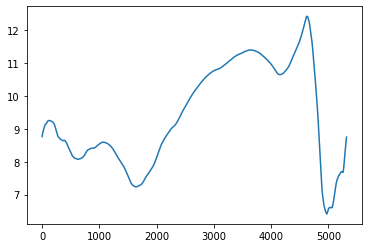

In [224]:
a,d = pywt.dwt(S0,'db4', 'smooth')
d.fill(0)
S0r = pywt.idwt(a,d,'db4')
for i in range(5):
  a,d = pywt.dwt(S0r,'db4')
  d.fill(0);
  S0r = pywt.idwt(a,d,'db4')
qrange = noise_mean*attack_percentage
for i in range(len(S0r)):
  if S0r[i]<0:
    S0r[i]=-S0r[i]
  elif S0r[i]>=2*qrange:
    S0r[i]=qrange
S0r=lowpassfilter(S0r, 0.64)
# df = pd.DataFrame(dict(
#     x = np.arange(0,trH,1),
#     y = S0r
# ))
# fig = px.line(df, x="x", y="y", title="Denoise S0") 
# fig.add_vrect(x0=half, x1=half_close)
# fig.show(0)
plt.plot(np.arange(0,trH,1),np.array(S0r))

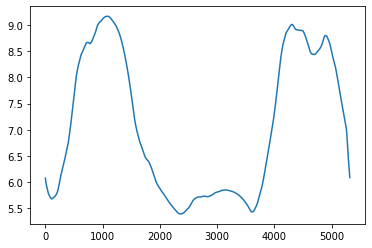

In [225]:
a,d = pywt.dwt(T0,'db4')
d.fill(0)
T0r = pywt.idwt(a,d,'db4')
for i in range(5):
  a,d = pywt.dwt(T0r,'db4')
  d.fill(0)
  T0r = pywt.idwt(a,d,'db4')

reqrange=Tattack_percentage*Tnoise_mean
for i in range(len(T0r)):
  if T0r[i]<=0:
    T0r[i]=0
  elif T0r[i]>=2*reqrange:
    T0r[i]=reqrange

T0r=lowpassfilter(T0r, 2)
# df2 = pd.DataFrame(dict(
#     x = np.arange(0,trH,1),
#     y = T0r
# ))
# fig2 = px.line(df2, x="x", y="y", title="Denoise T0") 
# fig2.add_vrect(x0=sH, x1=eH)
# fig2.show(0)
plt.plot(np.arange(0,trH,1),np.array(T0r))

LSTM Implementation

In [226]:
import tensorflow as tf
import numpy as np 
from tensorflow import keras 
from tensorflow.keras import layers 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# !pip install -U keras_tuner
# import keras_tuner as kt

In [227]:
X = np.array(np.floor(S0r))
X_val = np.array(np.floor(T0r))
dtarget = np.array(targetSequence)
X_val = X_val.reshape(len(X_val),1,1)
X= X.reshape(len(X),1,1)

In [228]:
# dropout =0
# model = Sequential()
# model.add(LSTM(4, return_sequences=True, input_shape=(1,1)))
# model.add(Dropout(dropout))
# model.add(LSTM(512, return_sequences=True))
# model.add(Dropout(dropout))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(dropout))
# model.add(LSTM(64))
# model.add(Dropout(dropout))
# model.add(Dense(1, activation="sigmoid"))
# model.compile(
#     loss=keras.losses.BinaryCrossentropy(from_logits=False),
#     optimizer='adam',
#     metrics=['accuracy']
# )
model = load_model(proj_dir+'/frc_5RPD.h5')
# model = load_model(proj_dir+'/frc_1RPD.h5')
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 4)              96        
                                                                 
 dropout_16 (Dropout)        (None, 1, 4)              0         
                                                                 
 lstm_17 (LSTM)              (None, 1, 512)            1058816   
                                                                 
 dropout_17 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 256)            787456    
                                                                 
 dropout_18 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_19 (LSTM)              (None, 64)               

In [229]:
# history = model.fit(X,dtarget, epochs=50, batch_size=12,shuffle=False)

In [230]:
predictions = model.predict(X_val, verbose=0)

In [231]:
# import os
# model.save(proj_dir+'/frc_5RPD.h5')

In [235]:
predict = predictions.flatten()
meanPredict = np.mean(predict)
for i in range(trH):
  if predict[i]>=(meanPredict):
    predict[i]=1
  else:
    predict[i]=0
df = pd.DataFrame(dict(
    x = np.arange(0,tsH,1),
    y = np.array(predict)
))
df1 = pd.DataFrame(dict(
    x = np.arange(0,tsH,1),
    y = np.array(validation_seq)
))
# plt.ylabel('Induced Attack Result',color='w')
# plt.xlabel('Time',color='w')
# plt.xticks(color='w')
# plt.yticks(color='w')
# # plt.plot(np.arange(0,trH,1),np.array(predict))
# plt.plot(np.arange(0,trH,1),np.array(validation_seq))
fig1 = px.line(df1, x="x", y="y", title="Prediction sequence") 
fig1.show(0)
fig = px.line(df, x="x", y="y", title="Validation sequence") 
fig.show(0)

In [233]:
a=np.array(validation_seq)-np.array(predict)
count = 0
for i in range(len(a)):
  if a[i]==1:
    count+=1
print(100 - (count/trH)*100)

100.0


In [234]:
# class TuneModel(kt.HyperModel):
#   def build(self, hp):
#     model = keras.Sequential()
#     model.add(LSTM( # input layer
#         units=4,
#         return_sequences=True,
#         input_shape=(1,1),
#         # dropout=hp.Float("dropout", min_value=0, max_value=0.9, step=0.1),
#     ))
#     model.add(LSTM( # first hidden layer
#       units=512,
#       return_sequences=True,
#       # dropout=hp.Float("dropout", min_value=0, max_value=0.9, step=0.1),
#     ))
#     model.add(LSTM( # second hidden layer
#       units=256,
#       return_sequences=True,
#       # dropout=hp.Float("dropout", min_value=0, max_value=0.9, step=0.1),
#     ))
#     model.add(LSTM( # third hidden layer
#       units=64,
#       return_sequences=True,
#       # dropout=hp.Float("dropout", min_value=0, max_value=0.9, step=0.1),
#     ))
#     model.add(Dense( # output (Dense) layer
#       units=1,
#       activation="sigmoid",
#     ))
#     model.compile(
#       loss=keras.losses.BinaryCrossentropy(from_logits=False),
#       optimizer='adam',
#       metrics=["accuracy"]
#     )
    
#     return model

#     def fit(self, hp, model, *args, **kwargs):
#       return model.fit(
#           *args,
#           batch_size=hp.Choice("batch_size", [12, 120]),
#           **kwargs,
#       )

# # build tuner object
# ''' tuner = kt.RandomSearch(
#     TuneModel(),
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     directory=".",
#     project_name="tune_hypermodel"
# ) '''

# tuner = kt.BayesianOptimization(
#     TuneModel(),
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     allow_new_entries=True,
#     directory=".",
#     project_name="tune_hypermodel",
# )

# # print search space summary
# tuner.search_space_summary()

# X_tune = np.array(np.floor(S0r))
# X_val_tune = np.array(np.floor(T0r))
# dtarget_tune = np.array(targetSequence)
# dtarget_tune = dtarget_tune.reshape(dtarget_tune.size, 1, 1)

# X_val_tune = X_val_tune.reshape(len(X_val_tune), 1, 1)
# X_tune = X_tune.reshape(len(X_tune), 1, 1)

# # since yval is part of validation_data, it needs to have the same size as xval or else
# # we get a KeyValue error during tuning
# yval_fin = yval.reshape(len(x), 1, 1)

# # search with the tuner to find optimal hyperparameters
# # use callbacks EarlyStopping to tune epochs
# # epochs set to 50 for testing purposes, can increase later once everything is working
# # following line gives KeyError: val_accuracy because of tuner's objective parameter
# tuner.search(X_tune, dtarget_tune, epochs=100, shuffle=False, validation_data=(xval, yval_fin), callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=3)])

# # Get the top 3 models
# models = tuner.get_best_models(num_models=3)
# best_model = models[0]
# best_model.summary()

# # sec_best_model = models[1]
# # sec_best_model.summary()

# # third_best_model = models[2]
# # third_best_model.summary()

# # print summary of tuner's results
# tuner.results_summary()
